# Equifinality Testing

Something that might add a lot of noise to coefficient estimation is equifinality in site-specific models. This Notebook analyzes the actual impact of such equifinality.

The basic procedure for a given watershed:

- Fit a calibrated model to the full timeseries. (We're interested in equally-performant coefficient sets, not in cal/val uncertainty, so we don't use a validation period.)
- Evaluate performance.
- Now, generate N random parameter sets, uniformly distributed. See which have less than an x% RMSE penalty and identify a behavioral envelope (think GLUE).
- Analyze distributions.

The immediate result, for $G$ gages and $p$ parameters, is a $(G\cdot N)\times p$ matrix of parameter sets mapped to a vector of $G\cdot N$ percentage RMSE penalties and a matrix of $G\times p$ original (fitted) parameter sets. This can be analyzed in a variety of ways; two major ones come to mind:

- Scatterplots showing whether the behavioral envelope varies with the value of the coefficient. (Not very enlightening, but I left the code in.)
- Scatterplot of RMSE impact vs variable offset, showing how sensitive the variable is.
- Scatterplot of RMSE impact vs reference value, showing where opportunities for improvement tend to concentrate.
- Histograms of behavioral variability by site, identifying how variable the sensitivity is.

Another interesting question will be whether any parameter sets actually have a *negative* penalty, i.e., outperform the fitted coefficient set. (This is a distinct behavior from a, strictly speaking, calibrated model, since our site parameters aren't actually calibrated but rather explicitly computed from the data.)

For this test, we disable the anomaly GAM because setting it up for the randomized models would be logistically annoying.

# Setup

In [1]:
import NEWT
from rtseason import ThreeSine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import os
import scipy
from scipy.stats.qmc import LatinHypercube
sns.set_context("paper")
bp = "/scratch/dphilippus/notebooks/next_validation/"

In [2]:
dev_data = pd.read_csv(bp + "DevDataBuffers.csv", dtype={"id": "str"}, parse_dates=["date"])[
    ["id", "date", "day", "temperature", "tmax"]
]
dev_data = dev_data.loc[(dev_data["temperature"] > -0.5) & (dev_data["temperature"] < 40)]

# Reference Performance

In [3]:
def perf_wcoef(site):
    model = NEWT.Watershed.from_data(site, use_anomgam=False)
    if model is None:
        return None
    pred = model.run_series(site)
    perf = NEWT.analysis.perf_summary(pred)["RMSE"]
    coefs = model.coefs_to_df().drop(columns=["R2", "RMSE"])
    print("|", end="")
    return pd.concat([coefs, perf], axis=1)

In [4]:
with warnings.catch_warnings(action="ignore"):
    reference = dev_data.groupby("id").apply(perf_wcoef, include_groups=False).droplevel(1)

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [5]:
del dev_data
reference

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,at_coef,RMSE
id,,,,,,,,,,
01010000,8.227527,11.664508,323.0,27.5,120.0,236.0,1.989669,3.269881,0.313388,1.819758
01011000,8.547659,11.735706,322.0,27.0,120.0,204.0,2.563314,2.746746,0.271996,1.510067
01018035,9.074948,12.007753,321.0,28.0,120.0,206.0,1.838306,2.569034,0.364230,1.560736
01038000,10.871231,12.433309,319.0,27.0,169.0,200.0,0.899632,1.966065,0.380036,1.318067
010642505,8.232986,9.252760,321.0,26.0,122.0,233.0,1.766506,1.030557,0.333147,1.141534
...,...,...,...,...,...,...,...,...,...,...
385903107210800,7.163091,9.258731,300.0,87.0,143.0,201.0,2.083604,1.409694,0.375744,1.682636
394220106431500,6.965011,7.357272,324.0,84.0,156.0,237.0,2.823831,1.979052,0.257349,1.281264
402114105350101,4.352286,7.339022,301.0,88.0,153.0,237.0,2.495065,0.984321,0.329488,1.207342


# Randomized Parameters

We'll just generate one set of 10,000 for all sites, just to make things simple. Each parameter is allowed to be anywhere in the observed range (above).

Runtime was approx. 61 hours for 10,000 members x 921 sites (9,210,000 runs).

## Generate Samples

In [6]:
rawmat = pd.DataFrame(LatinHypercube(9).random(n=10000), columns=reference.columns[:9])

In [7]:
mins = reference[rawmat.columns].min()
maxes = reference[rawmat.columns].max()
ranges = maxes - mins
rpar = rawmat * ranges + mins

In [8]:
rpar

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,at_coef
0,28.005691,13.572429,363.755230,9.131295,166.969415,218.680251,-0.533642,-1.157867,0.064512
1,24.176095,15.060145,324.241272,21.592572,178.484586,227.951272,3.576726,0.164736,-0.090871
2,13.061379,14.404657,300.994139,84.889387,125.600158,206.345785,4.257610,0.849935,0.276636
3,12.182556,1.176874,300.672381,98.600486,150.503210,205.813202,-1.064433,1.433451,0.496613
4,7.756826,7.759374,339.918220,15.932179,176.068326,204.315586,3.734171,-1.605058,-0.012406
...,...,...,...,...,...,...,...,...,...
9995,8.963477,7.837071,323.720910,50.089365,173.208980,206.944222,0.222619,-1.979956,0.017206
9996,29.212051,4.733597,330.948286,53.980056,148.416739,210.506937,3.185647,-0.243201,-0.146226
9997,12.669908,6.607717,327.850524,44.764603,163.115482,236.097470,-2.574539,1.978069,0.099148
9998,27.820714,2.462861,337.963023,68.107504,121.234601,223.791724,2.815779,4.415026,0.635137


## Compute Performance

To avoid an excessively large result, for each site, we only keep the 1000 rows with the best performance. This will result in approx. 1M rows total, instead of the unmanageable 10M resulting from storing everything.

The first site, with 10k iterations, took about 200 seconds, or 0.02 seconds per run. That's fast individually, but too many to be manageable in a Jupyter notebook. This Notebook has been converted to Python and is running in the background.

In [9]:
def random_perf(params=rpar):
    def inner(site):
        daily = site.groupby(["day"], as_index=False)["tmax"].mean().rename(columns={"tmax": "mean_tmax"})
        pser = pd.Series([
            NEWT.analysis.perf_summary(
                NEWT.Watershed(
                    seasonality=ThreeSine(
                        Intercept=prow.Intercept,
                        Amplitude=prow.Amplitude,
                        SpringSummer=prow.SpringSummer,
                        FallWinter=prow.FallWinter,
                        SpringDay=prow.SpringDay,
                        SummerDay=prow.SummerDay,
                        FallDay=prow.FallDay,
                        WinterDay=prow.WinterDay
                    ),
                    at_coef=prow.at_coef,
                    at_day=daily
                ).run_series(site)
            )["RMSE"].iloc[0]
            for prow in params.itertuples()
        ]).rename("RMSE")
        print("|", end="")
        return pd.concat([params, pser], axis=1).sort_values("RMSE").head(1000)
    return inner

In [10]:
outfile = bp + "results/EquifinalMatrix.csv"
rerun = False
if os.path.exists(outfile) and not rerun:
    rpdata = pd.read_csv(outfile, dtype={"id": "str"}, index_col=[0, 1])
else:
    with warnings.catch_warnings(action="ignore"):
        start = time.time()
        rpdata = dev_data.loc[dev_data["id"].isin(reference.index)
                             ].groupby("id").apply(random_perf(), include_groups=False)
        print(f"Runtime: {(time.time() - start)/60: .02f} minutes for {len(rpar)} iterations over {len(reference)} sites")
        rpdata.to_csv(outfile)

## Analyze Performance

In [11]:
def behavioral(threshold, rpdata=rpdata, reference=reference):
    delta = (rpdata - reference)
    delta["RMSE"] = delta["RMSE"] / reference["RMSE"] * 100
    behav = delta.loc[delta["RMSE"] < threshold].melt("RMSE", ignore_index=False)
    reflong = reference.drop(columns=["RMSE"]).melt(ignore_index=False).rename(columns={"value": "ref_value"})
    res = reflong.merge(behav, on=["id", "variable"], how="left").assign(width=threshold)
    res.loc[res["value"].isna(), "value"] = 0
    # We also want to know how the offset relates to the total variability possible
    return res.reset_index().merge(
        pd.DataFrame(ranges).reset_index().rename(columns={"index": "variable", 0: "ref_range"}),
        on="variable"
    ).set_index("id")

behbins = pd.concat([behavioral(i) for i in [1, 2, 5, 10]])
behbins

,variable,ref_value,RMSE,value,width,ref_range
id,,,,,,
01010000,Intercept,8.227527,-27.223804,-2.644485,1,27.014903
01010000,Intercept,8.227527,-26.679329,-1.838703,1,27.014903
01010000,Intercept,8.227527,-26.558204,-2.430038,1,27.014903
01010000,Intercept,8.227527,-26.047503,-2.144891,1,27.014903
01010000,Intercept,8.227527,-25.007628,-2.037606,1,27.014903
...,...,...,...,...,...,...
385903107210800,at_coef,0.375744,9.431748,0.156654,10,1.005099
394220106431500,at_coef,0.257349,NaN,0.000000,10,1.005099
402114105350101,at_coef,0.329488,NaN,0.000000,10,1.005099


In [12]:
behbins.assign(better = lambda x: x["RMSE"] < 0).groupby("id")["better"].any().mean()

0.06840390879478828

In [13]:
behbins.assign(exists = lambda x: ~x["RMSE"].isna()).groupby("id")["exists"].any().mean()

0.3995656894679696

In [17]:
# What proportion of iterations are behavioral for a given width?
N = 10000 * len(reference) * 8
behbins.groupby("width")["RMSE"].count() / N

width
1     0.000134
2     0.000157
5     0.000245
10    0.000540
Name: RMSE, dtype: float64

In [33]:
# What proportion of variance is explained by the fitted value?
(behbins.loc[(behbins["width"] == 10) & (~behbins["RMSE"].isna())].
 assign(value=lambda x: x["value"] + x["ref_value"]).
 groupby("variable")[["ref_value", "value"]].corr().
 filter(like="ref_value", axis=0)["value"])**2

variable               
Amplitude     ref_value    0.865989
FallDay       ref_value    0.002139
FallWinter    ref_value    0.043568
Intercept     ref_value    0.936864
SpringDay     ref_value    0.000296
SpringSummer  ref_value    0.001085
SummerDay     ref_value    0.000022
WinterDay     ref_value    0.004630
at_coef       ref_value    0.312093
Name: value, dtype: float64

In [37]:
# What proportion of variance is explained by the fitted value for just improved coef sets?
(behbins.loc[behbins["RMSE"] < 0].
 assign(value=lambda x: x["value"] + x["ref_value"]).
 groupby("variable")[["ref_value", "value"]].corr().
 filter(like="ref_value", axis=0)["value"])**2

variable               
Amplitude     ref_value    0.691112
FallDay       ref_value    0.001394
FallWinter    ref_value    0.016255
Intercept     ref_value    0.787115
SpringDay     ref_value    0.002012
SpringSummer  ref_value    0.003053
SummerDay     ref_value    0.000022
WinterDay     ref_value    0.000154
at_coef       ref_value    0.130580
Name: value, dtype: float64

In [40]:
# What proportion of variance is explained by the fitted value including no-behavioral sites?
(behbins.loc[behbins["width"] == 10].
 assign(value=lambda x: x["value"] + x["ref_value"]).
 groupby("variable")[["ref_value", "value"]].corr().
 filter(like="ref_value", axis=0)["value"])**2

variable               
Amplitude     ref_value    0.865880
FallDay       ref_value    0.000751
FallWinter    ref_value    0.053476
Intercept     ref_value    0.941544
SpringDay     ref_value    0.012551
SpringSummer  ref_value    0.001703
SummerDay     ref_value    0.021480
WinterDay     ref_value    0.033150
at_coef       ref_value    0.338435
Name: value, dtype: float64

In [20]:
# sns.relplot(behbins.loc[-behbins["RMSE"].isna()], x="ref_value", y="value", col="variable",
#             row="width", height=2, facet_kws={"sharex": False, "sharey": False})

In [21]:
ranges

Intercept        27.014903
Amplitude        15.724800
FallDay          65.000000
WinterDay       109.000000
SpringDay        60.000000
SummerDay        40.000000
SpringSummer      7.507740
FallWinter        7.255054
at_coef           1.005099
dtype: float64

I printed out the ranges above for reference. We know, of course, that the max RMSE-delta will be 10% from the filter above. Short of that threshold, we see some interesting effects. Note that wherever we say a variable's offset improves performance, that indicates only a possibility - some 80% of the time, the fitted coefficient set is at least 10% better than all tested alternatives. A total of 7% of sites have at least one superior parameter set.

- Reduced Intercept sometimes correlates to improved performance. Increased Intercept almost never does. This suggests a tendency to overestimate Intercept, presumably because sampling will be summer-biased. There are no behavioral parameter sets with an offset >3 or <-4 C.
- Amplitude is the exact opposite. Offsets of up to +5 C or so may produce improved performance.
- SpringSummer is totally insensitive.
- FallWinter can improve performance for a large range of values, but cuts off at increases >2 C.
- SpringDay can improve performance for any offset, but especially positive offsets.
- SummerDay is insensitive.
- FallDay is like SpringDay.
- WinterDay only improves performance for positive or slightly negative offsets (>-10).
- Air temperature sensitivity can improve performance for positive or slightly negative offsets (>-0.2).

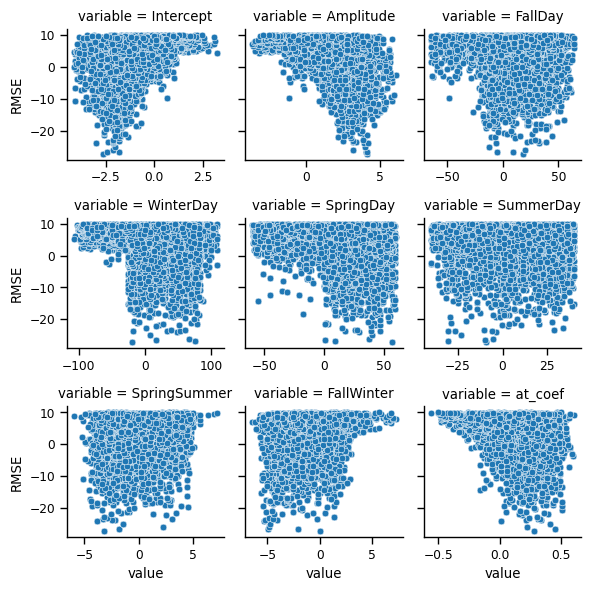

In [22]:
sns.relplot(behbins.loc[-behbins["RMSE"].isna()], x="value", y="RMSE", col="variable",
            col_wrap=3, height=2, facet_kws={"sharex": False})

In [36]:
# Identify whether sites allow no behavioral sets, behavioral sets but no improvement, or improvement
behbins["shift"] = 0
behbins.loc[-behbins["RMSE"].isna(), "shift"] = 1
behbins.loc[behbins["RMSE"] < 0, "shift"] = 2
names = pd.DataFrame({"shift": [0, 1, 2], "which": ["No Behavioral", "Behavioral", "Improved"]})
shifts = (behbins.groupby(["id", "variable"])[["ref_value", "shift"]].max().
          reset_index().
          merge(names, on="shift"))
shifts

,id,variable,ref_value,shift,which
0,01010000,Amplitude,11.664508,2,Improved
1,01010000,FallDay,323.000000,2,Improved
2,01010000,FallWinter,3.269881,2,Improved
3,01010000,Intercept,8.227527,2,Improved
4,01010000,SpringDay,120.000000,2,Improved
...,...,...,...,...,...
8284,453004122510301,SpringDay,158.000000,0,No Behavioral
8285,453004122510301,SpringSummer,0.377075,0,No Behavioral
8286,453004122510301,SummerDay,205.000000,0,No Behavioral
8287,453004122510301,WinterDay,85.000000,0,No Behavioral


Looking at where improvements occur, we see:

- Intercept: no-behavioral and behavioral are about the same distributions, no-behavioral being a little wider, but opportunities for improvement are concentrated a few degrees lower. This makes sense because those would be the sites prone to seasonal data omissions, whereas even lower mean temperatures would indicate that the winter data are not omitted.
- Amplitude: fairly similar distributions overall. Improved sites are very slightly higher-amplitude, but not by enough to be sure.
- SpringSummer: no difference. Explains the insensitivity above, it's apparently pretty random.
- FallWinter: FallWinter: improved tends to be a little higher and has a wider distribution, interestingly, which suggests that the (fitted) extremes are usually not best-fit. Since the extremes are usually high, that explains why negative offsets tend to improve performance.
- SpringDay: all three distributions are bimodal. Behavioral and Improved have the same two modes, but weighted differently. No-Behavioral shares one mode, for late spring, but has a different second mode. Mid-range spring days are very rarely improved by an offset, whereas early-range spring days are particularly likely to be.
- SummerDay: no difference.
- FallDay: little difference. Improvements are slightly more likely to happen for early and, especially, late falls, and less likely for mid-range falls. Improvements usually come from offsetting to later.
- WinterDay: All distributions are bimodal and behavioral sets are distributed about the same as no-behavioral ones, but improvements are most likely to occur at the early mode, around day 20-30, and to shift later.
- Sensitivity: similar distributions. Improvements are slightly more likely to occur for low sensitivities, so there's a tendency to underestimate.

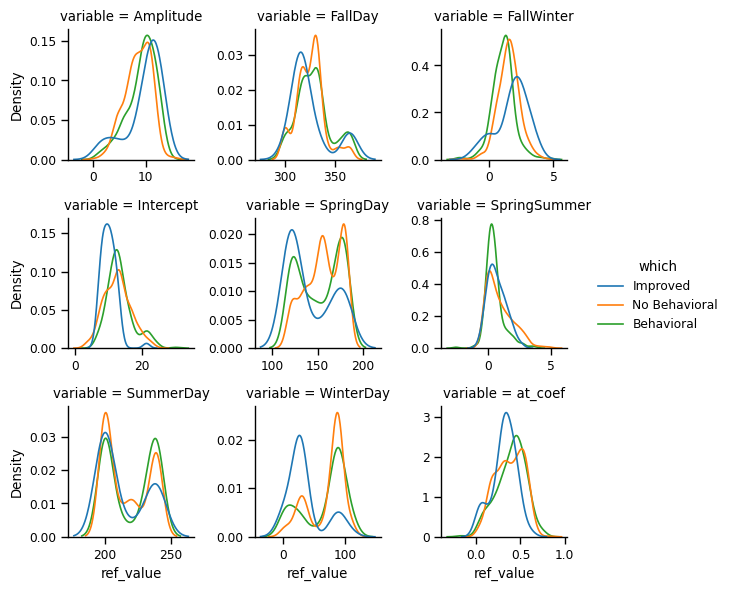

In [39]:
sns.displot(shifts, x="ref_value", col="variable", col_wrap=3, hue="which",
            kind="kde", height=2, common_norm=False, facet_kws={"sharex": False, "sharey": False})

Note that the large majority of sites don't have any behavioral combinations, at any threshold. However, of those that do, we see significant variation in the allowable range of variation. The dates are all low-sensitivity, with some of them even weighted towards larger offsets. Intercept and Amplitude are extremely sensitive, with no behavioral parameter sets above ~40% offset for Amplitude, and ~15% for Intercept. FallWinter, interestingly, is more sensitive than SpringSummer at low values, but has a higher allowable cutoff, up to 100%, whereas SpringSummer cuts off at about 70%. Air temperature sensitivity is quite sensitive.

Restricting the bins to exclude the lower bins, we see some new information:

- The better-performing FallDay values actually tend to have a larger offset, so there's a bit of a bimodal thing going on - either zero change or a large change.
- The same thing happens for WinterDay.
- Otherwise, the distributions across bins are fairly similar.

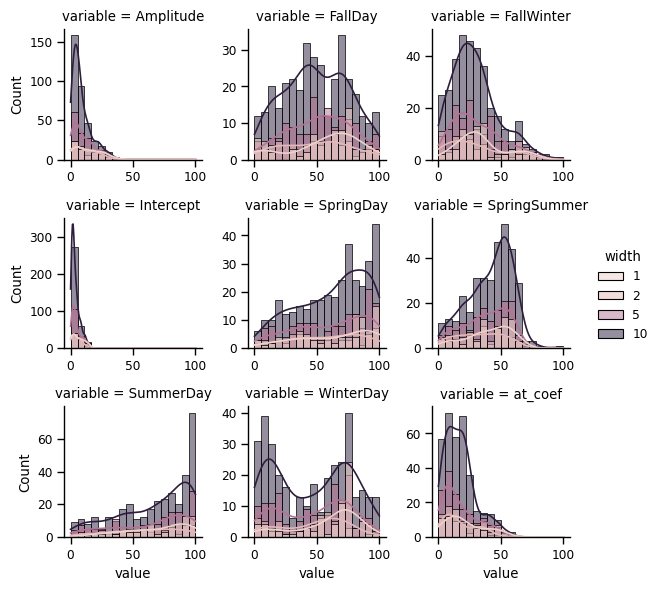

In [24]:
left_end = pd.DataFrame({"width": [1, 2, 5, 10], "lower": [-99, 1, 2, 5]})
ewid = (behbins.assign(value=lambda x: x["value"].abs()/x["ref_range"]*100).
        reset_index().
        merge(left_end, on="width"))
ewid = ewid.loc[ewid["RMSE"] > ewid["lower"]].groupby(["id", "variable", "width"])["value"].max().reset_index()
sns.displot(ewid, x="value", col="variable", hue="width", col_wrap=3, height=2, kde=True, facet_kws={"sharex": False, "sharey": False})